# Functions to Convert GHCN Daily Files to DataFrames, .CSV

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import date
from functools import reduce

DLY_PATH = os.path.join("static", "src", "ghcnd_all")
CSV_PATH = os.path.join("static", "csv")

In [2]:
class GHCN_Daily_Conversion:
    def __init__(self, station, dly_path=DLY_PATH, csv_path=CSV_PATH, keep_nas=True):
        self.station = station
        self.src = dly_path
        self.dest = csv_path
        self.keep_nas = keep_nas
        self.daily_df = None
        self.converted_df = None
        
        assert os.path.exists(self.src), 'Source path is invalid'
        assert os.path.exists(self.dest), 'Destination path does not exist'
            
    def __repr__(self):
        return (f'{self.__class__.__name__}({self.station})')


    def read_daily(self):
        def make_column_formats ():
            def value_format_tuples (i):
                return [(21 + i*8, 26 + i*8), (26 + i*8, 27 +i*8), (27 +i*8, 28 +i*8), (28 + i*8, 29+i*8)]
            # column parameters for the first four fields:
            # the tuples represent the columns in the .dly file for a given field as [first, last+1)
            base_format = [(0,11), (11, 15), (15,17), (17,21)]
            for i in range(31):
                base_format.extend(value_format_tuples(i))

            return base_format
        def make_column_names():
            def value_name_strings (i):
                return ['day_' + str(i), 'mflag_' + str(i), 'qflag_' + str(i), 'sflag_' + str(i)]
            base_column_names = ['station_id', 'year', 'month', 'element']
            for i in range(31):
                base_column_names.extend(value_name_strings(i+1))

            return base_column_names
  
        dly_file_name = self.station + '.dly'
        dly_path = os.path.join(self.src, dly_file_name)
        if not os.path.isfile(dly_path):
            print(f"Could not find {dly_path}")
            return
    
        colspecs = make_column_formats()
        colnames = make_column_names()
        df = pd.read_fwf(dly_path, colspecs=colspecs, header=None, names=colnames, na_values=-9999)
    
        self.daily_df = df
        
    def all_values(self, target_element):
        """
        Return all values - including missing values - except for days with invalid dates: Feb 30, 2019, etc.
        """
        day_names = ['day_' + str(i+1) for i in range(31)]
        q_df = self.daily_df[self.daily_df.element == target_element]

        num_months = q_df.shape[0]

        dfs = []

        for i in range(num_months):
            current_row = q_df.iloc[i,:]
            current_year = current_row.year
            current_month = current_row.month

            if self.keep_nas:
                valid_days = []
                for day in day_names:
                    try:
                        make_date = date(year=current_year, month=current_month, day=int(day[4:]))
                        valid_days.append(day)
                    except ValueError as e:
                        pass
                non_missing_values = current_row[valid_days]
            else: 
                 non_missing_values = current_row[day_names].dropna()
                    
            non_missing_index = non_missing_values.index
            non_missing_days = [int(day[4:]) for day in non_missing_index]
            non_missing_dates = [date(year=current_year, month=current_month, day=day) for day in non_missing_days]
            m_flags = current_row[['mflag_' + str(day) for day in non_missing_days]]
            q_flags = current_row[['qflag_' + str(day) for day in non_missing_days]]
            s_flags = current_row[['sflag_' + str(day) for day in non_missing_days]]
            row_df = pd.DataFrame({'date': non_missing_dates,\
                                   target_element: non_missing_values.values,\
                                   f'{target_element}_mflag': m_flags.values,\
                                   f'{target_element}_qflag': q_flags.values,\
                                   f'{target_element}_sflag': s_flags.values})
            dfs.append(row_df)

        return pd.concat(dfs)
    
    def convert_daily_to_df(self):

        elements = set(self.daily_df.element.values)

        dfs = []

        for element in elements:
            e_df = self.all_values(element)
            dfs.append(e_df)

        final_df = reduce(lambda df1,df2: pd.merge(df1,df2,on='date',how='outer'), dfs)

        self.converted_df = final_df
        
    def write_converted_to_csv(self):
        csv_file_name = self.station + '.csv'
        csv_path = os.path.join(self.dest, csv_file_name)
        
        if type(tmp.converted_df) == pd.core.frame.DataFrame:
            self.converted_df.to_csv(csv_path, index=False)
    
    def convert(self):
        self.read_daily()
        self.convert_daily_to_df()
        self.write_converted_to_csv()
        
    def first_non_missing_day(self, target_element):
        day_names = ['day_' + str(i+1) for i in range(31)]
        q_df = self.daily_df[self.daily_df.element == target_element]
        # first row will be the earliest
        earliest_row = q_df.iloc[0,:]

        earliest_year = earliest_row.year
        earliest_month = earliest_row.month

        # extract the elements
        earliest_day = earliest_row[day_names].dropna().index[0]
        earliest_day = int(earliest_day[4:])

        # switch to a datetime object later
        return date(year=earliest_year, month=earliest_month, day=earliest_day)
    
    def last_non_missing_day(self, target_element):
        day_names = ['day_' + str(i+1) for i in range(31)]
        q_df = self.daily_df[self.daily_df.element == target_element]
        last_row = q_df.shape[0] - 1

        # last row will be the latest
        latest_row = q_df.iloc[last_row,:]

        latest_year = latest_row.year
        latest_month = latest_row.month

        # extract the elements
        latest_day = latest_row[day_names].dropna().index[-1]
        latest_day = int(latest_day[4:])

        # switch to a datetime object later
        return date(year=latest_year, month=latest_month, day=latest_day)
    
    def range_of_dates(self, target_element):
        return self.first_non_missing_day(target_element), self.last_non_missing_day(target_element)
    
    def date_ranges(self):
        # Return the ranges of nonmissing dates for each element as a dict
        results = {}
        elements = set(self.daily_df.element.tolist())
        for element in elements:
            results[element] = self.range_of_dates(element)
            
        return results

In [3]:
tmp = GHCN_Daily_Conversion('US1MNAA0002')

In [4]:
tmp

GHCN_Daily_Conversion(US1MNAA0002)

In [5]:
tmp.read_daily()

In [6]:
tmp.daily_df.head()

,station_id,year,month,element,day_1,mflag_1,qflag_1,sflag_1,day_2,mflag_2,...,qflag_29,sflag_29,day_30,mflag_30,qflag_30,sflag_30,day_31,mflag_31,qflag_31,sflag_31
0,US1MNAA0002,2009,12,PRCP,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,N,5.0,NaN,NaN,N
1,US1MNAA0002,2009,12,SNOW,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,N,3.0,NaN,NaN,N
2,US1MNAA0002,2009,12,SNWD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,297.0,NaN,NaN,N,NaN,NaN,NaN,NaN
3,US1MNAA0002,2009,12,WESD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,615.0,NaN,NaN,N,NaN,NaN,NaN,NaN
4,US1MNAA0002,2009,12,WESF,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
tmp.daily_df

,station_id,year,month,element,day_1,mflag_1,qflag_1,sflag_1,day_2,mflag_2,...,qflag_29,sflag_29,day_30,mflag_30,qflag_30,sflag_30,day_31,mflag_31,qflag_31,sflag_31
0,US1MNAA0002,2009,12,PRCP,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,N,5.0,NaN,NaN,N
1,US1MNAA0002,2009,12,SNOW,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,N,3.0,NaN,NaN,N
2,US1MNAA0002,2009,12,SNWD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,297.0,NaN,NaN,N,NaN,NaN,NaN,NaN
3,US1MNAA0002,2009,12,WESD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,615.0,NaN,NaN,N,NaN,NaN,NaN,NaN
4,US1MNAA0002,2009,12,WESF,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,US1MNAA0002,2010,1,PRCP,0.0,NaN,NaN,N,0.0,NaN,...,NaN,N,0.0,NaN,NaN,N,0.0,NaN,NaN,N
6,US1MNAA0002,2010,1,SNOW,0.0,NaN,NaN,N,0.0,NaN,...,NaN,N,0.0,NaN,NaN,N,0.0,NaN,NaN,N
7,US1MNAA0002,2010,1,SNWD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,US1MNAA0002,2010,1,WESD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,US1MNAA0002,2010,1,WESF,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
tmp.daily_df.query('element == "PRCP"').iloc[0,:]

station_id    US1MNAA0002
year                 2009
month                  12
element              PRCP
day_1                 NaN
mflag_1               NaN
qflag_1               NaN
sflag_1               NaN
day_2                 NaN
mflag_2               NaN
qflag_2               NaN
sflag_2               NaN
day_3                 NaN
mflag_3               NaN
qflag_3               NaN
sflag_3               NaN
day_4                 NaN
mflag_4               NaN
qflag_4               NaN
sflag_4               NaN
day_5                 NaN
mflag_5               NaN
qflag_5               NaN
sflag_5               NaN
day_6                 NaN
mflag_6               NaN
qflag_6               NaN
sflag_6               NaN
day_7                 NaN
mflag_7               NaN
                 ...     
qflag_24              NaN
sflag_24                N
day_25                165
mflag_25              NaN
qflag_25              NaN
sflag_25                N
day_26                130
mflag_26    

In [9]:
tmp.first_non_missing_day('PRCP')

datetime.date(2009, 12, 22)

In [10]:
tmp.last_non_missing_day("PRCP")

datetime.date(2015, 11, 12)

In [11]:
tmp.range_of_dates("PRCP")

(datetime.date(2009, 12, 22), datetime.date(2015, 11, 12))

In [12]:
tmp.date_ranges()

{'PRCP': (datetime.date(2009, 12, 22), datetime.date(2015, 11, 12)),
 'SNWD': (datetime.date(2009, 12, 23), datetime.date(2014, 1, 26)),
 'SNOW': (datetime.date(2009, 12, 22), datetime.date(2013, 6, 30)),
 'WESF': (datetime.date(2009, 12, 22), datetime.date(2011, 11, 20)),
 'WESD': (datetime.date(2009, 12, 23), datetime.date(2014, 1, 26))}

In [13]:
tmp.keep_nas = False # should really do this in a method

In [14]:
tmp.convert_daily_to_df()

In [15]:
tmp.converted_df.shape

(677, 21)

In [16]:
tmp.converted_df.head()

,date,PRCP,PRCP_mflag,PRCP_qflag,PRCP_sflag,SNWD,SNWD_mflag,SNWD_qflag,SNWD_sflag,SNOW,...,SNOW_qflag,SNOW_sflag,WESF,WESF_mflag,WESF_qflag,WESF_sflag,WESD,WESD_mflag,WESD_qflag,WESD_sflag
0,2009-12-22,25,NaN,NaN,N,NaN,NaN,NaN,NaN,0,...,NaN,N,25,NaN,NaN,N,NaN,NaN,NaN,NaN
1,2009-12-23,0,NaN,NaN,N,165,NaN,NaN,N,0,...,NaN,N,NaN,NaN,NaN,NaN,196,NaN,NaN,N
2,2009-12-24,142,NaN,NaN,N,NaN,NaN,NaN,NaN,147,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-12-25,165,NaN,NaN,N,NaN,NaN,NaN,NaN,109,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-12-26,130,NaN,NaN,N,NaN,NaN,NaN,NaN,25,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
tmp.converted_df.describe()

,date,PRCP,PRCP_mflag,PRCP_qflag,PRCP_sflag,SNWD,SNWD_mflag,SNWD_qflag,SNWD_sflag,SNOW,...,SNOW_qflag,SNOW_sflag,WESF,WESF_mflag,WESF_qflag,WESF_sflag,WESD,WESD_mflag,WESD_qflag,WESD_sflag
count,677,676.0,47,0.0,676,8.0,0.0,0.0,8,337.0,...,0.0,337,9.0,0.0,0.0,9,9.0,0.0,0.0,9
unique,677,107.0,1,0.0,1,8.0,0.0,0.0,1,16.0,...,0.0,1,9.0,0.0,0.0,1,9.0,0.0,0.0,1
top,2014-06-23,0.0,T,NaN,N,318.0,NaN,NaN,N,0.0,...,NaN,N,51.0,NaN,NaN,N,361.0,NaN,NaN,N
freq,1,360.0,47,NaN,676,1.0,NaN,NaN,8,322.0,...,NaN,337,1.0,NaN,NaN,9,1.0,NaN,NaN,9


In [18]:
tmp.all_values('SNWD').describe()

,date,SNWD,SNWD_mflag,SNWD_qflag,SNWD_sflag
count,8,8.0,0.0,0.0,8
unique,8,8.0,0.0,0.0,1
top,2009-12-30,318.0,NaN,NaN,N
freq,1,1.0,NaN,NaN,8


# What is the outcome when we set keep_nas=True?

In [19]:
tmp.keep_nas = True

In [20]:
tmp.convert_daily_to_df()

In [21]:
tmp.converted_df.shape

(1435, 21)

In [22]:
tmp.converted_df.head()

,date,PRCP,PRCP_mflag,PRCP_qflag,PRCP_sflag,SNWD,SNWD_mflag,SNWD_qflag,SNWD_sflag,SNOW,...,SNOW_qflag,SNOW_sflag,WESF,WESF_mflag,WESF_qflag,WESF_sflag,WESD,WESD_mflag,WESD_qflag,WESD_sflag
0,2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
tmp.converted_df.describe()

,date,PRCP,PRCP_mflag,PRCP_qflag,PRCP_sflag,SNWD,SNWD_mflag,SNWD_qflag,SNWD_sflag,SNOW,...,SNOW_qflag,SNOW_sflag,WESF,WESF_mflag,WESF_qflag,WESF_sflag,WESD,WESD_mflag,WESD_qflag,WESD_sflag
count,1435,676.0,47,0.0,676,8.0,0.0,0.0,8,337.0,...,0.0,337,9.0,0.0,0.0,9,9.0,0.0,0.0,9
unique,1435,107.0,1,0.0,1,8.0,0.0,0.0,1,16.0,...,0.0,1,9.0,0.0,0.0,1,9.0,0.0,0.0,1
top,2012-06-23,0.0,T,NaN,N,165.0,NaN,NaN,N,0.0,...,NaN,N,51.0,NaN,NaN,N,196.0,NaN,NaN,N
freq,1,360.0,47,NaN,676,1.0,NaN,NaN,8,322.0,...,NaN,337,1.0,NaN,NaN,9,1.0,NaN,NaN,9


In [24]:
tmp.write_converted_to_csv()

In [25]:
tmp.convert() # Do all the steps at once - this was with keep_nas = True

In [26]:
import matplotlib.pyplot as plt

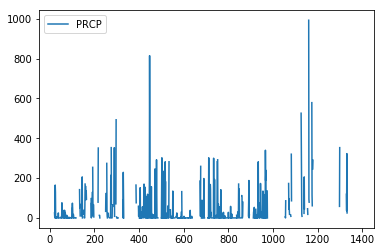

In [28]:
tmp.converted_df[['date', 'PRCP']].plot()

In [39]:
import seaborn as sns

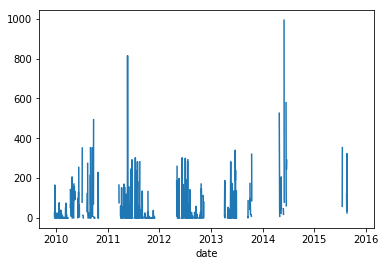

In [46]:
df = tmp.converted_df
df.set_index('date', inplace=True)
df['PRCP'].plot()

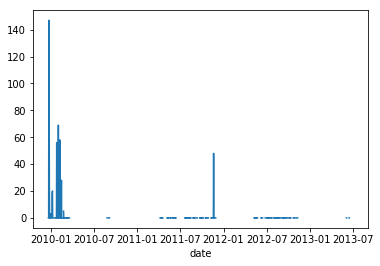

In [48]:
#df = tmp.converted_df
#df.set_index('date', inplace=True)
df['SNOW'].plot()

In [50]:
stations = ['USW00094960']

for station in stations:
    stat_conv = GHCN_Daily_Conversion(station)
    stat_conv.convert()


In [51]:
stat_conv.station

'USW00094960'

In [52]:
stat_conv.date_ranges()

{'WT06': (datetime.date(2018, 2, 19), datetime.date(2018, 3, 5)),
 'WDF2': (datetime.date(1998, 4, 1), datetime.date(2019, 8, 8)),
 'PGTM': (datetime.date(1998, 4, 1), datetime.date(2019, 8, 8)),
 'WT19': (datetime.date(2009, 10, 23), datetime.date(2013, 3, 10)),
 'WT21': (datetime.date(2009, 9, 3), datetime.date(2012, 3, 13)),
 'WT03': (datetime.date(2010, 4, 13), datetime.date(2018, 6, 9)),
 'WDF5': (datetime.date(1998, 4, 1), datetime.date(2019, 8, 8)),
 'PRCP': (datetime.date(1998, 4, 1), datetime.date(2019, 8, 8)),
 'WSF2': (datetime.date(1998, 4, 1), datetime.date(2019, 8, 8)),
 'WSF5': (datetime.date(1998, 4, 1), datetime.date(2019, 8, 8)),
 'WT01': (datetime.date(2009, 9, 3), datetime.date(2019, 6, 28)),
 'SNOW': (datetime.date(1999, 1, 23), datetime.date(1999, 3, 6)),
 'AWND': (datetime.date(1998, 4, 1), datetime.date(2019, 8, 8)),
 'WT02': (datetime.date(2009, 9, 5), datetime.date(2018, 5, 31)),
 'WT05': (datetime.date(2009, 9, 9), datetime.date(2010, 12, 30)),
 'WT11': (date